## Imports

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
# Optional: for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# Replace 'output_properties-v1.csv' with the actual path to your file
try:
  output_props = pd.read_csv('output_properties-v2.csv')
  print(output_props.head())  # Print the first few rows to verify it loaded correctly
  print(output_props.shape)
except FileNotFoundError:
  print("File not found. Please make sure the file path is correct.")

try:
  input_e_props = pd.read_csv('input_properties-e-v2.csv')
  print(input_e_props.head())  # Print the first few rows to verify it loaded correctly
  print(input_e_props.shape)
except FileNotFoundError:
  print("File not found. Please make sure the file path is correct.")

try:
  input_f_props = pd.read_csv('input_properties-f-v2.csv')
  print(input_f_props.head())  # Print the first few rows to verify it loaded correctly
  print(input_f_props.shape)
except FileNotFoundError:
  print("File not found. Please make sure the file path is correct.")


     vf  ematerial  fmaterial           c44       e15         q15       μ11  \
0  0.05          1          1  4.766571e+10  0.015891  496.356224  0.000142   
1  0.10          1          1  4.828090e+10  0.027298  449.900677  0.000129   
2  0.15          1          1  4.893927e+10  0.039258  409.485667  0.000118   
3  0.20          1          1  4.962150e+10  0.052453  372.497082  0.000108   
4  0.25          1          1  5.031985e+10  0.067351  338.035646  0.000098   

            ϵ11           α11       ρ  
0  9.727373e-11 -4.046668e-12  5320.0  
1  1.077914e-10 -6.693664e-12  5340.0  
2  1.188914e-10 -9.065879e-12  5360.0  
3  1.311074e-10 -1.127972e-11  5380.0  
4  1.448213e-10 -1.337401e-11  5400.0  
(1045, 10)
   material_code          c55f  e15f  q15f          ϵ11f      μ11f  α11f    ρf
0              1  4.400000e+10  11.4     0  9.820000e-09  0.000005     0  5700
1              2  2.560000e+10  12.7     0  6.460000e-09  0.000005     0  7500
2              3  2.500000e+10  13.5 

## Data Prepration

In [22]:
# prompt: Make a new dataframe.
# and iterate through all the elements in output_props and find assign the properties given in the input_f_props and input_e_props such such that if the ematerial==material_code in input_e_props then replace ematerial with all the 6 properties given in the input_e_props. same goes wiht the input_f_props and fmateria

temp_dataset = output_props.copy()

for index, row in temp_dataset.iterrows():
  e_material = row['ematerial']
  f_material = row['fmaterial']

  # Find matching rows in input_e_props and input_f_props
  matching_e_props = input_e_props[input_e_props['material_code'] == e_material]
  matching_f_props = input_f_props[input_f_props['material_code'] == f_material]

  if not matching_e_props.empty:
    # Replace ematerial properties with values from input_e_props
    for col in ['c55f', 'e15f', 'q15f', 'ϵ11f', 'μ11f', 'α11f', 'ρf']:
      temp_dataset.loc[index, col] = matching_e_props[col].iloc[0]

  if not matching_f_props.empty:
    # Replace fmaterial properties with values from input_f_props
    # for col in ['f_density', 'f_youngs_modulus', 'f_poissons_ratio', 'f_thermal_conductivity', 'f_specific_heat', 'f_thermal_expansion']:
    # for col in ['c55m', 'e15m', 'q15m', 'ϵ11m', 'μ11m', 'α11m', 'ρm']:
    for col in ['c55f', 'e15f', 'q15f', 'ϵ11f', 'μ11f', 'α11f', 'ρf']:
      col_name = col[:-1]+'m'
      temp_dataset.loc[index, col_name] = matching_f_props[col].iloc[0]

temp_dataset.drop(columns=['ematerial', 'fmaterial'], inplace=True)

print(temp_dataset.shape)
print(temp_dataset.columns.tolist())

#22 columns 1 vf 7*2 props and 7 output props

(1045, 22)
['vf', 'c44', 'e15', 'q15', 'μ11', 'ϵ11', 'α11', 'ρ', 'c55f', 'e15f', 'q15f', 'ϵ11f', 'μ11f', 'α11f', 'ρf', 'c55m', 'e15m', 'q15m', 'ϵ11m', 'μ11m', 'α11m', 'ρm']


In [23]:
# prompt: cut the last 12 coloumns in the dataset and paste them after the first column

last_12_cols = temp_dataset.iloc[:, -14:]
first_cols = temp_dataset.iloc[:,0]
remaining_cols = temp_dataset.iloc[:, 1:-14]
dataset = pd.concat([first_cols, last_12_cols, remaining_cols], axis=1)
print(dataset)
print(dataset.columns.tolist())

        vf          c55f  e15f  q15f          ϵ11f      μ11f  α11f      ρf  \
0     0.05  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
1     0.10  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
2     0.15  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
3     0.20  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
4     0.25  4.400000e+10  11.4   0.0  9.820000e-09  0.000005   0.0  5700.0   
...    ...           ...   ...   ...           ...       ...   ...     ...   
1040  0.75  4.740000e+10   5.9   0.0  2.580000e-07  0.000001   0.0  5700.0   
1041  0.80  4.740000e+10   5.9   0.0  2.580000e-07  0.000001   0.0  5700.0   
1042  0.85  4.740000e+10   5.9   0.0  2.580000e-07  0.000001   0.0  5700.0   
1043  0.90  4.740000e+10   5.9   0.0  2.580000e-07  0.000001   0.0  5700.0   
1044  0.95  4.740000e+10   5.9   0.0  2.580000e-07  0.000001   0.0  5700.0   

              c55m  e15m  ...      μ11m  α11m      ρm          

In [24]:
X = dataset.iloc[:, :15].values  # 15 input features
y = dataset.iloc[:, 15:].values  # 7 target properties
print(X.shape, y.shape)

(1045, 15) (1045, 7)


In [6]:
# # prompt: Convert all the string values in X into float type

# # Convert all string values to float in X
# for column in range(X.shape[1]):
#   if type(X[0,column]) == str:
#     try:
#       X[:,column] = pd.to_numeric(X[:,column], errors='coerce').astype(float)
#     except ValueError:
#       print(f"Could not convert column '{column}' to numeric.")


In [25]:

# Standardize the input features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Standardize the target variables
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


print("X_train.shape" ,X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape",y_test.shape)

X_train.shape (836, 15)
y_train.shape (836, 7)
X_test.shape (209, 15)
y_test.shape (209, 7)


## Data Insights

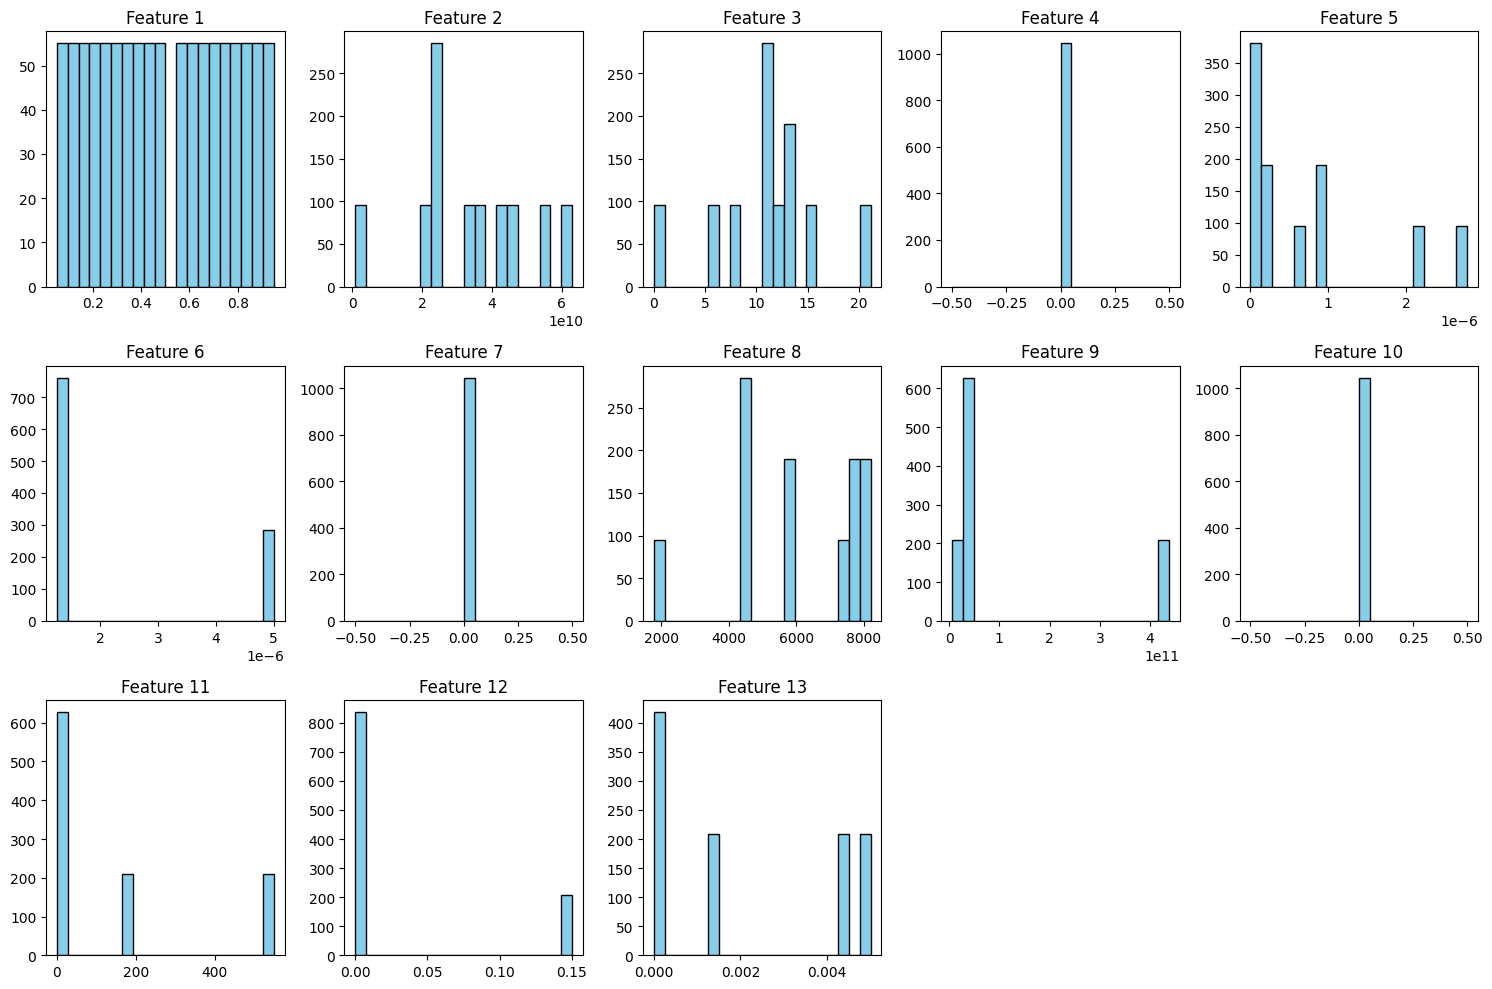

In [26]:
#We'll plot histograms to visualize the distribution of the input features (material properties and volume fraction).

plt.figure(figsize=(15, 10))
for i in range(13):
    plt.subplot(3, 5, i+1)
    plt.hist(dataset.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Feature {i+1}')
plt.tight_layout()
plt.show()

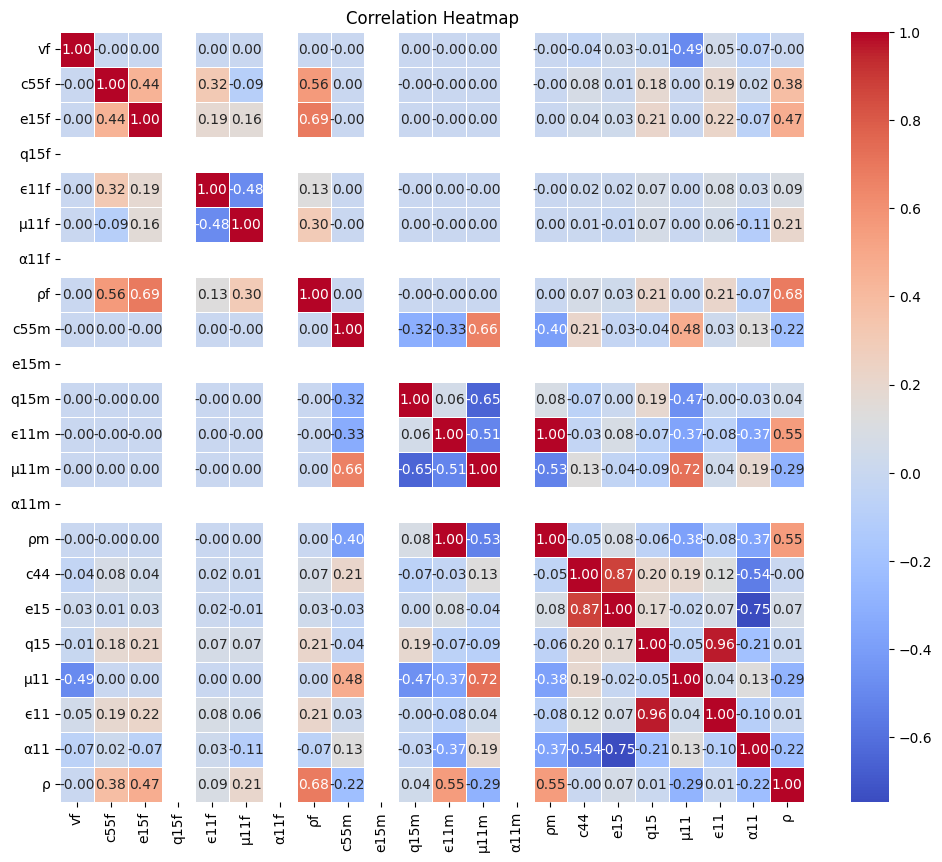

In [9]:
# Calculate the correlation matrix
corr_matrix = dataset.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#what does this map shows?
#The correlation heatmap shows the relationship between the input features and the target properties.
#The values range from -1 to 1, where 1 indicates a strong positive correlation, -1 indicates a strong negative correlation, and 0 indicates no correlation.
#The diagonal line shows the correlation of each feature with itself, which is always 1.
#From the heatmap, we can see that some features have a strong positive or negative correlation with the target properties, while others have little to no correlation.


## Model-Neural Network

### Building the neural-network model

In [10]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

def build_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=(input_shape,)))

    # Hidden layers with proper initialization
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))

    # Output layer with 7 neurons (one for each property)
    model.add(layers.Dense(7))

    # Compile the model with a smaller learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', r2_score])

    return model

def build_advanced_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=(input_shape,)))

    # Hidden layers with Batch Normalization and L2 Regularization
    model.add(layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))

    # Output layer with 7 neurons (one for each property)
    model.add(layers.Dense(7))

    # Compile the model with learning rate scheduling
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


In [11]:
# Build and compile the model
model = build_model(X_train.shape[1])
# model = build_advanced_model(X_train.shape[1])

# Model summary
model.summary()

/Users/vivek/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,615 (49.28 KB)

 Trainable params: 12,615 (49.28 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model


In [12]:
# Train the model with early stopping and a reasonable batch size
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=8, callbacks=[early_stopping])



Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8009 - mae: 1.2102 - r2_score: -4.5611 - val_loss: 1.2035 - val_mae: 0.7340 - val_r2_score: -1.1745
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 1.5365 - mae: 0.8142 - r2_score: -1.7430 - val_loss: 0.8590 - val_mae: 0.5564 - val_r2_score: -0.2894
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 1.0241 - mae: 0.6678 - r2_score: -0.8892 - val_loss: 0.7390 - val_mae: 0.4743 - val_r2_score: 0.0111
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 1.6686 - mae: 0.6289 - r2_score: -0.5243 - val_loss: 0.6859 - val_mae: 0.4285 - val_r2_score: 0.1393
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 1.9753 - mae: 0.6158 - r2_score: -0.2557 - val_loss: 0.6538 - val_mae: 0.4041 - val_r2_score: 0.2056
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.7198 - mae: 0.5013 - r2_score: -0.1903 - val_loss: 0.6266 - val_mae: 0.3840 - val_r2_score: 0.2703
Epoch 7/100
84/84 ━━━━━━━━━━

### Find Hyperparameter

In [13]:
# prompt: Use kerastuner and find me the best model and build it
import keras_tuner as kt

def build_model(hp):
  model = keras.Sequential()
  model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                         activation='relu', input_shape=(X_train.shape[1],)))
  for i in range(hp.Int('num_layers', 1, 3)):
    model.add(layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                           activation='relu'))
  model.add(layers.Dense(y_train.shape[1]))  # Output layer with 7 neurons for regression

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mae'])
  return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_mae_per_epoch = history.history['val_mae']
best_epoch = val_mae_per_epoch.index(min(val_mae_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Reloading Tuner from my_dir/intro_to_kt/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384, and the optimal learning rate for the optimizer
is 0.001.

Epoch 1/50


/Users/vivek/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2457 - mae: 0.4112 - val_loss: 0.5205 - val_mae: 0.2932
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2777 - mae: 0.3099 - val_loss: 0.3856 - val_mae: 0.1878
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6736 - mae: 0.1869 - val_loss: 0.3324 - val_mae: 0.1555
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6469 - mae: 0.1804 - val_loss: 0.2639 - val_mae: 0.1361
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5044 - mae: 0.1475 - val_loss: 0.2330 - val_mae: 0.1298
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7903 - mae: 0.1857 - val_loss: 0.1835 - val_mae: 0.1213
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8026 - mae: 0.1661 - val_loss: 0.1529 - val_mae: 0.1331
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5797 - mae: 0.1556 - val_loss: 0.1513 - val_mae: 0.1235
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2670 - mae: 0.1380 - va

### Evaluate the Model

### Plotting

In [14]:
print(history.params)
print(history.history.keys())


{'verbose': 'auto', 'epochs': 50, 'steps': 21}
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


KeyError: 'r2_score'

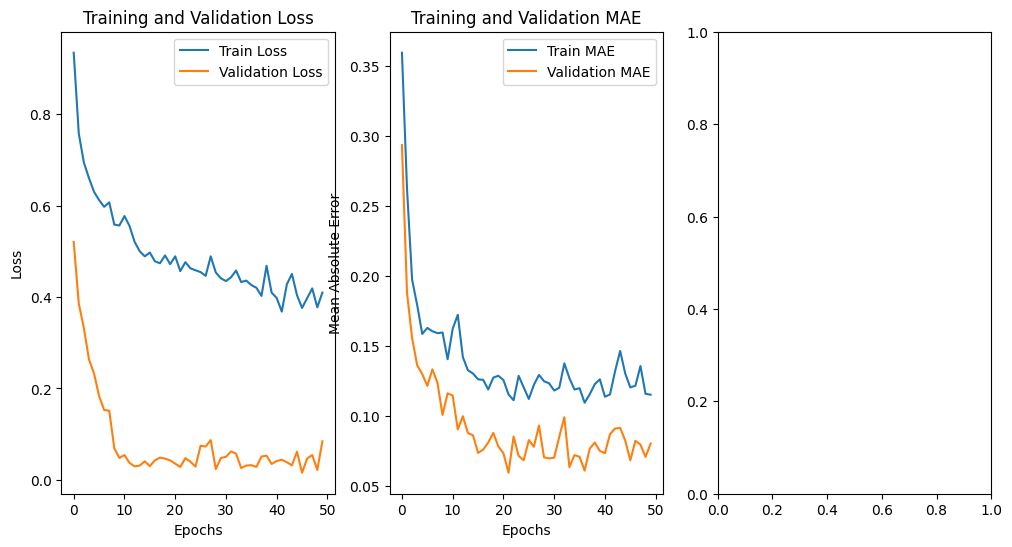

In [15]:
'''
3. Model Training Loss and Metrics Over Epochs
We'll visualize the training and validation loss/MAE over epochs to see if the model is converging and whether there are any signs of overfitting.

            ##SIMPLE MODEL
            
'''

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MAE
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# R Square
plt.subplot(1, 3, 3)
plt.plot(history.history['r2_score'], label='Train R^2')
plt.plot(history.history['val_r2_score'], label='Validation R^2')
plt.title('Training and Validation R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2')
plt.legend()


plt.tight_layout()
plt.show()

In [16]:

# Predict and inverse transform the predictions and true values
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {rmse}")

'''Test MAE: 0.17333467304706573
Test RMSE: 84210643871.23975

Test MAE: 0.13074041903018951
Test RMSE: 80479505609.30318

'''

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


NameError: name 'test_mae' is not defined

In [ ]:

# Calculate R^2 score for each of the 7 output variables
r2_scores = []
for i in range(y_test_original.shape[1]):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    r2_scores.append(r2)

# Plot R^2 scores for each output variable
plt.figure(figsize=(10, 6))
plt.bar(range(1, 8), r2_scores, color='skyblue')
plt.xlabel('Output Variable Index')
plt.ylabel('R² Score')
plt.title('R² Score for Each Output Variable')
plt.xticks(range(1, 8))
plt.show()

# Print R^2 scores for reference
for i, score in enumerate(r2_scores, 1):
    print(f"R² Score for output variable {i}: {score:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step


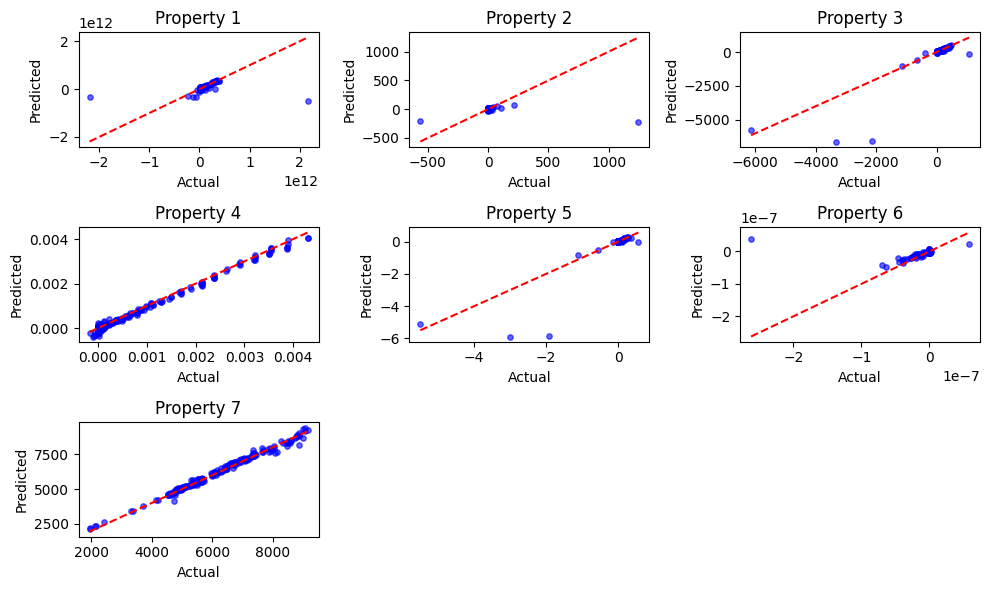

In [18]:
'''
4. Actual vs. Predicted Values

We will plot the actual vs. predicted values for the 7 target properties on the test set to understand how well the model performs.
'''

# Predict on the test set and inverse transform the predictions and true values
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
for i in range(7):
    plt.subplot(3, 3, i+1)
    plt.scatter(y_test_original[:, i], y_pred[:, i], color='blue', alpha=0.6, s=15)
    plt.plot([min(y_test_original[:, i]), max(y_test_original[:, i])],
             [min(y_test_original[:, i]), max(y_test_original[:, i])], 'r--')
    plt.title(f'Property {i+1}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


### Custom Testing




In [19]:
def compare_single_row_vectors(predicted, actual):
  """Compares two single row vectors and provides a detailed output.

  Args:
    predicted: A numpy array representing the predicted values.
    actual: A numpy array representing the actual values.

  Returns:
    A dictionary containing the following metrics:
      - absolute_difference: Absolute difference between predicted and actual.
      - relative_difference: Relative difference between predicted and actual (in percentage).
      - mean_absolute_error: Mean Absolute Error.
      - root_mean_squared_error: Root Mean Squared Error.
  """

  absolute_difference = np.abs(predicted - actual)
  relative_difference = np.abs((predicted - actual) / actual) * 100  # Avoid division by zero
  mean_absolute_error = np.mean(np.abs(predicted - actual))
  root_mean_squared_error = np.sqrt(np.mean((predicted - actual)**2))

  results = {
      "absolute_difference": absolute_difference,
      "relative_difference": relative_difference,
      "mean_absolute_error": mean_absolute_error,
      "root_mean_squared_error": root_mean_squared_error
  }

  return results

def compare_vectors(vector1, vector2):
    
    # Create a DataFrame for tabular comparison
    df = pd.DataFrame({
        'Vector 1': vector1,
        'Vector 2': vector2,
        'Difference': [v1 - v2 if v1 is not None and v2 is not None else None for v1, v2 in zip(vector1, vector2)]
    })
    
    return df



def predict_and_compare(custom_X, original_y=None):
    """
    Function to input a custom vector, transform it, predict the output, inverse transform the prediction,
    and compare it with the original answer if provided.

    Args:
    custom_X (list or numpy array): The custom input vector.
    original_y (list or numpy array, optional): The original output vector for comparison.

    Returns:
    dict: A dictionary containing the predicted output and comparison results if original_y is provided.
    """
    # Convert the custom input to a numpy array if it's a list
    if isinstance(custom_X, list):
        custom_X = np.array(custom_X)
    custom_X = custom_X.reshape(1, -1)  # Reshape to a single row

    custom_X_scaled = scaler_X.transform(custom_X)
    custom_y_pred_scaled = model.predict(custom_X_scaled)
    custom_y_pred = scaler_y.inverse_transform(custom_y_pred_scaled)

    result = {
        "Predicted Output": custom_y_pred[0],
        "Predicted Output Scaled": custom_y_pred_scaled[0]
    }

    if original_y is not None:
        if isinstance(original_y, list):
            original_y = np.array(original_y)
        comparison_results = compare_single_row_vectors(custom_y_pred[0], original_y)
        result["Comparison Results"] = comparison_results

    return result

# Example usage:
custom_X = [
    # Replace with your desired input values
    0.5, 10000, 0.3, 200, 500, 0.000015, 1000, 10000, 0.3, 200, 500, 0.000015, 1000, 0.0001, 100
]
original_y = [
    # Replace with the actual original output values for comparison
    4.76657088e+10, 1.58911049e-02, 4.96356224e+02, 1.42281371e-04,
    9.72737333e-11, -4.04666773e-12, 5.32000000e+03
]

custom_X = X[0]
original_y = y[0]

result = predict_and_compare(X[0], y[0])
print("Predicted Output:", *result["Predicted Output"])
print("Real Output      ", *original_y)
print("Predicted Output ", *result["Predicted Output Scaled"], end="\n\n")
print(compare_vectors(result["Predicted Output"], original_y))
print("\n\n")
if "Comparison Results" in result:
    print("Comparison Results:")
    for metric, value in result["Comparison Results"].items():
        print(f"{metric}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted Output: 44336300000.0 3.3925936 464.45645 1.000492e-05 -0.00326083 1.2574018e-10 5392.432
Real Output       47665708776.4155 0.015891104909231 496.3562235447875 0.0001422813709311 9.727373332703483e-11 -4.046667731750246e-12 5320.0
Predicted Output  -0.102891795 -0.005261302 0.998269 -0.7263928 0.02944117 0.17419119 -0.43640986

       Vector 1      Vector 2    Difference
0  4.433630e+10  4.766571e+10 -3.329409e+09
1  3.392594e+00  1.589110e-02  3.376703e+00
2  4.644565e+02  4.963562e+02 -3.189977e+01
3  1.000492e-05  1.422814e-04 -1.322765e-04
4 -3.260830e-03  9.727373e-11 -3.260830e-03
5  1.257402e-10 -4.046668e-12  1.297868e-10
6  5.392432e+03  5.320000e+03  7.243213e+01



Comparison Results:
absolute_difference: [3.32940874e+09 3.37670252e+00 3.18997721e+01 1.32276451e-04
 3.26083005e-03 1.29786850e-10 7.24321289e+01]
relative_difference: [6.98491396e+00 2.12490103e+04 6.42679000e+00 9.29682150e+01
 3.35222052e+09 3.20725245e+03 1.36

In [ ]:
print(X[0])
print(y[0])